In [1]:
# Importing dataset
!gdown --id 1zfWhdTXtVH10QVZZ03ivZS3PjPDg-vH7
import pandas as pd
import numpy as np
df = pd.read_csv ('sprint 3 data.csv')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zfWhdTXtVH10QVZZ03ivZS3PjPDg-vH7
To: /content/sprint 3 data.csv
100% 3.89M/3.89M [00:00<00:00, 186MB/s]


In [2]:
# Displaying to dataframe to understand its structure
df.head()
df.iloc[0]

# Checking for missing values
print(df.isnull().sum())

# Descriptive Statistics
print(df.describe())

# Identification of unsuitable data type for Service Actual Start dates
type(df.iloc[0]['Service Actual Start'])

# Converting date columns to datetime format
date_columns = ['DOB', 'Service Planned Start','Service Planned End', 'Service Actual Start', 'Service Actual End']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Converting numerical columns to appropriate types
numeric_columns = ['Total Client Hours', 'Total Worker Hours', 'Rate Unit', 'Total Cost Per Week']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Converting categorical columns to category type
category_columns = ['Gender', 'Service Provision Start Reason', 'Service Provision End Reason']
for col in category_columns:
    df[col] = df[col].astype('category')

# Show the updated data types
df_dtypes = df.dtypes

# Statistical summary of numerical columns
numerical_summary = df.describe()

# Proportion of missing values in each column
missing_values = df.isnull().mean().sort_values(ascending=False) * 100

# Distribution of categorical columns
categorical_summary = df.describe(include=['category'])

numerical_summary, missing_values, categorical_summary

WCCIS Client ID                      1
Gender                               1
DOB                                  1
Service Provision ID                 1
Service Planned Start             1803
Service Planned End               8293
Service Actual Start                 1
Service Actual End                1870
Service Provision Start Reason      16
Service Provision End Reason      1822
rate unit type                       1
Service Element1                     1
Service Element2                     1
Service Element3                     1
service delivery id                  1
Delivery Start Time                  1
Delivery End Time                    1
Units                                1
Monday                               1
Tuesday                              1
Wednesday                            1
Thursday                             1
Friday                               1
Saturday                             1
Sunday                               1
Total Client Hours       

<ipython-input-2-11fdc7489d10>:17: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')


(       WCCIS Client ID                            DOB  Service Provision ID  \
 count     1.167200e+04                          11672          1.167200e+04   
 mean      1.145075e+06  1970-01-01 00:00:00.000001939          1.556849e+06   
 min       4.383200e+04  1970-01-01 00:00:00.000001916          7.217040e+05   
 25%       9.731650e+05  1970-01-01 00:00:00.000001930          1.267860e+06   
 50%       9.974645e+05  1970-01-01 00:00:00.000001936          1.727507e+06   
 75%       1.144482e+06  1970-01-01 00:00:00.000001945          1.920830e+06   
 max       2.866424e+06  1970-01-01 00:00:00.000002002          1.993999e+06   
 std       3.715042e+05                            NaN          4.370561e+05   
 
                Service Planned Start            Service Planned End  \
 count                           4115                           1265   
 mean   2019-05-02 08:19:21.798298880  2019-07-19 06:19:04.031620352   
 min              2006-05-06 00:00:00            2013-02-05 00

In [3]:
# Handling missing values
# Numerical columns filled with median
for col in numeric_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Categorical columns filled with mode
for col in category_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Dropping Service Planned End column due to high % of missing data
df.drop(columns=['Service Planned End'], inplace=True)

# Handling outliers for the Total Cost Per Week column
cap_threshold = df['Total Cost Per Week'].quantile(0.95)
df['Total Cost Per Week'] = df['Total Cost Per Week'].clip(upper=cap_threshold)

In [4]:
# Feature Engineering
# Creating a new column 'Service Duration'
df['Service Duration'] = (df['Service Actual End'] - df['Service Actual Start']).dt.days

# Creating a binary column 'Late Start' indicating if the service started later than planned
df['Late Start'] = (df['Service Actual Start'] > df['Service Planned Start']).astype(int)

# Displaying the updated dataframe with the new features and the handled missing values
df[['Total Cost Per Week', 'Service Duration', 'Late Start']].describe()#, df.isnull().mean().sort_values(ascending=False) * 100

# Marking ongoing services in 'Service Duration' with -1 (indicating an ongoing service)
df['Service Duration'].fillna(-1, inplace=True)

# Removing rows with missing values in 'Service Actual End' as it will skew analyses related to Service Duration.
df.dropna(subset=['Service Actual End'], inplace=True)

In [5]:
# Closer inspection into the newly created Service Duration column
df[['Service Duration']].describe()#, df.isnull().mean().sort_values(ascending=False) * 100

# Filter the DataFrame to show only rows where 'Service Duration' is negative
negative_duration_rows = df[(df['Service Duration'] < 0) & (df['Service Duration'] != -1)]

# Display the 'Service Actual Start' and 'Service Actual End' columns for these rows
negative_duration_dates = negative_duration_rows[['Service Actual Start', 'Service Actual End']]
print(negative_duration_dates)

# Swapping of start and end dates for rows with a negative service duration
for index, row in negative_duration_rows.iterrows():
    # Swap the start and end dates
    df.at[index, 'Service Actual Start'], df.at[index, 'Service Actual End'] = \
    df.at[index, 'Service Actual End'], df.at[index, 'Service Actual Start']
    # Recalculate the duration
    df.at[index, 'Service Duration'] = (df.at[index, 'Service Actual End'] - df.at[index, 'Service Actual Start']).days

      Service Actual Start Service Actual End
8               2019-07-01         2019-01-14
120             2020-09-03         2020-03-09
123             2019-11-03         2019-03-12
225             2019-12-03         2019-05-12
226             2019-12-03         2019-05-12
...                    ...                ...
11388           2018-10-04         2018-08-23
11389           2018-10-04         2018-08-23
11552           2020-09-01         2020-01-17
11553           2020-09-01         2020-01-17
11615           2018-07-03         2018-03-07

[901 rows x 2 columns]


In [6]:
# Classifier development - Creation of 'Transfer' the binary target variable using Service Provision End Reasons

# Inspecting unique values in columns that might indicate a transfer to a new supplier
potential_indicators = ['Service Provision End Reason']

# Display unique values in these columns to understand potential indicators
unique_values = {column: df[column].unique().tolist() for column in potential_indicators}
unique_values

# Creating a binary target variable based on the 'Service Provision End Reason'
transfer_reasons = ['Change of Supplier', 'Continuing Service - New Supplier']
df['Transfer'] = df['Service Provision End Reason'].apply(lambda x: 1 if x in transfer_reasons else 0)

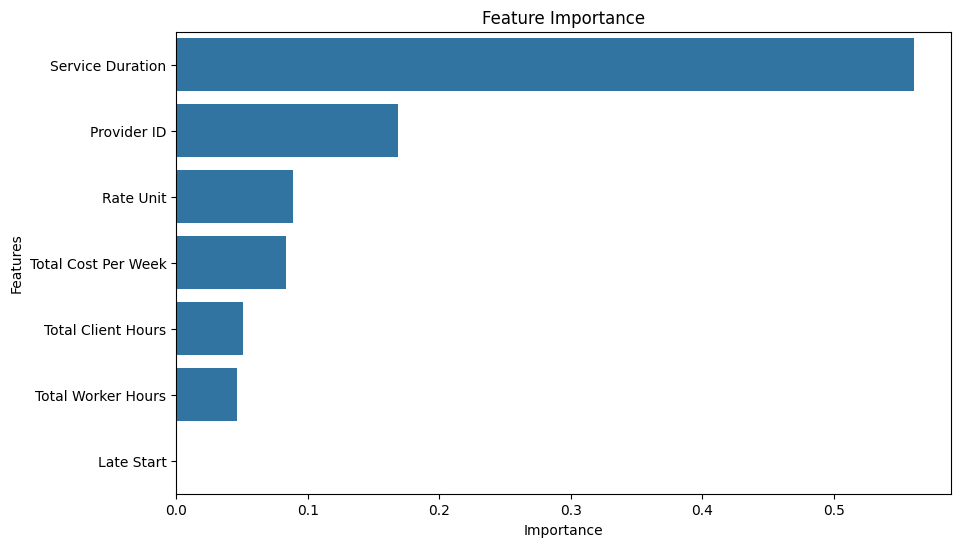

Accuracy: 0.9535951045385007
Precision: 0.631578947368421
Recall: 0.2376237623762376
F1 Score: 0.34532374100719426
ROC-AUC Score: 0.8268790588736293


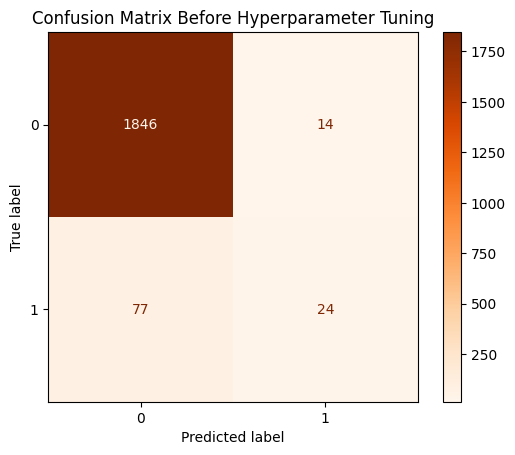

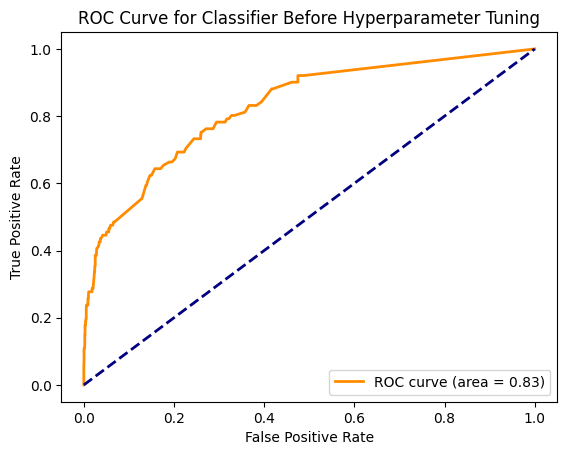

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
#import matplotlib.pyplot as plt
X = df[['Service Duration', 'Late Start', 'Total Client Hours', 'Total Worker Hours', 'Total Cost Per Week', 'Rate Unit', 'Provider ID']]
y = df['Transfer']  # The column indicating if the service package was transferred

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Obtain feature importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Visualising feature importance
#import matplotlib.pyplot as plt
#import seaborn as sns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC Score: {roc_auc}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)  # Changed color map
plt.title('Confusion Matrix Before Hyperparameter Tuning')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifier Before Hyperparameter Tuning')
plt.legend(loc="lower right")
plt.show()

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy with Best Estimator: 0.9546149923508415
Precision with Best Estimator: 0.65
Recall with Best Estimator: 0.25742574257425743
F1 Score with Best Estimator: 0.3687943262411348
ROC-AUC Score with Best Estimator: 0.8143298200787821


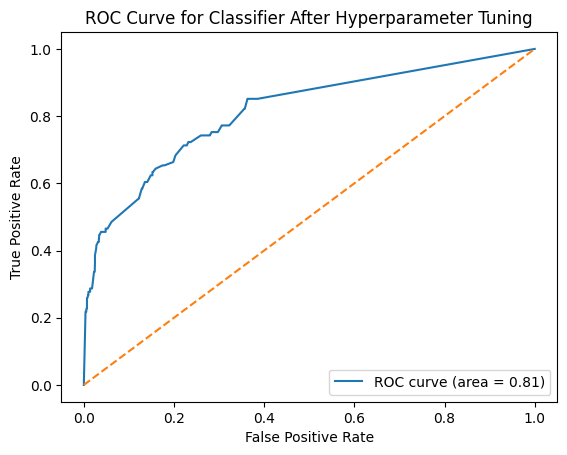

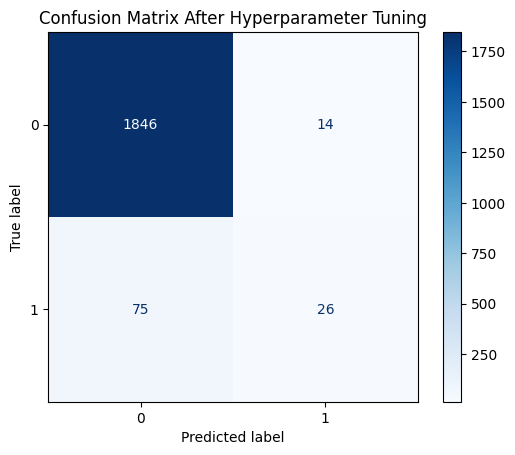

In [9]:
# Hyperparameter Tuning using GridSearchCV

# Define the parameter grid for RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Initialize the grid search model
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_clf = grid_search.best_estimator_

# Make predictions with the best estimator
y_pred = best_clf.predict(X_test)
y_pred_proba = best_clf.predict_proba(X_test)[:, 1]

# Calculate metrics with the best estimator
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics with the best estimator
print(f'Best Parameters: {best_params}')
print(f'Accuracy with Best Estimator: {accuracy}')
print(f'Precision with Best Estimator: {precision}')
print(f'Recall with Best Estimator: {recall}')
print(f'F1 Score with Best Estimator: {f1}')
print(f'ROC-AUC Score with Best Estimator: {roc_auc}')

# ROC-AUC Curve post hyperparameter tuning
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifier After Hyperparameter Tuning')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix post hyperparameter tuning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix After Hyperparameter Tuning')
plt.show()

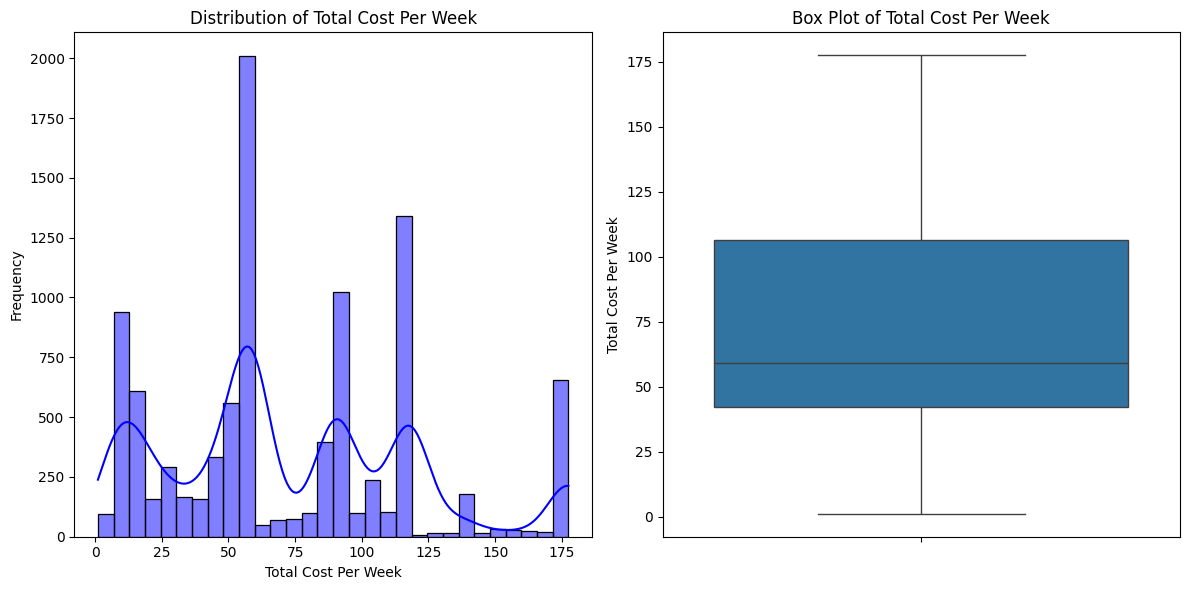

<ipython-input-10-3a22bd7eab66>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=provider_counts.index, y=provider_counts.values, palette='viridis')


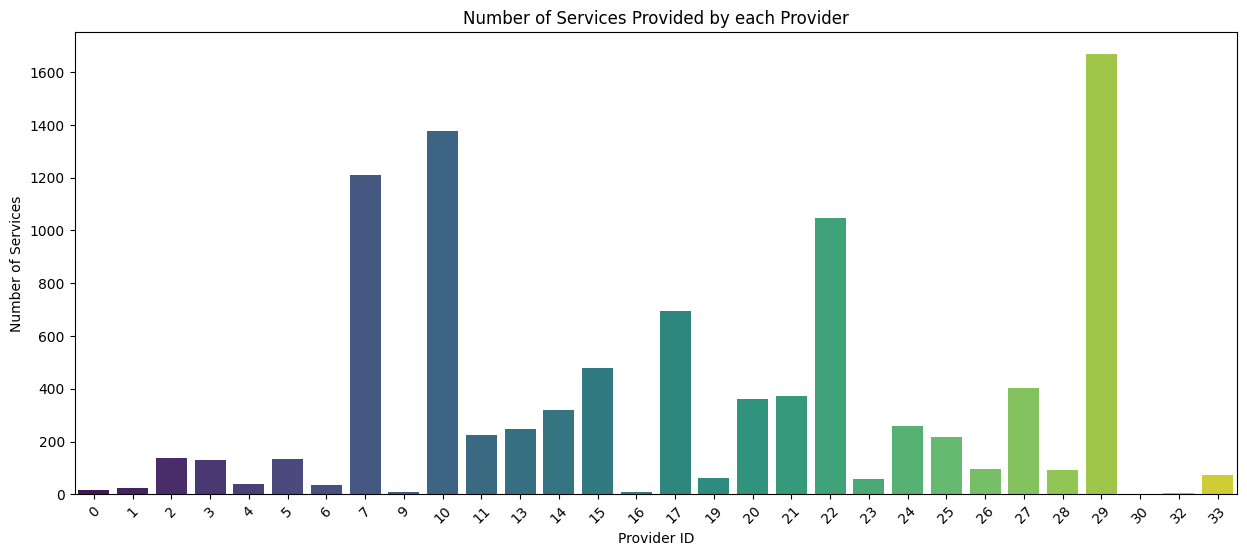

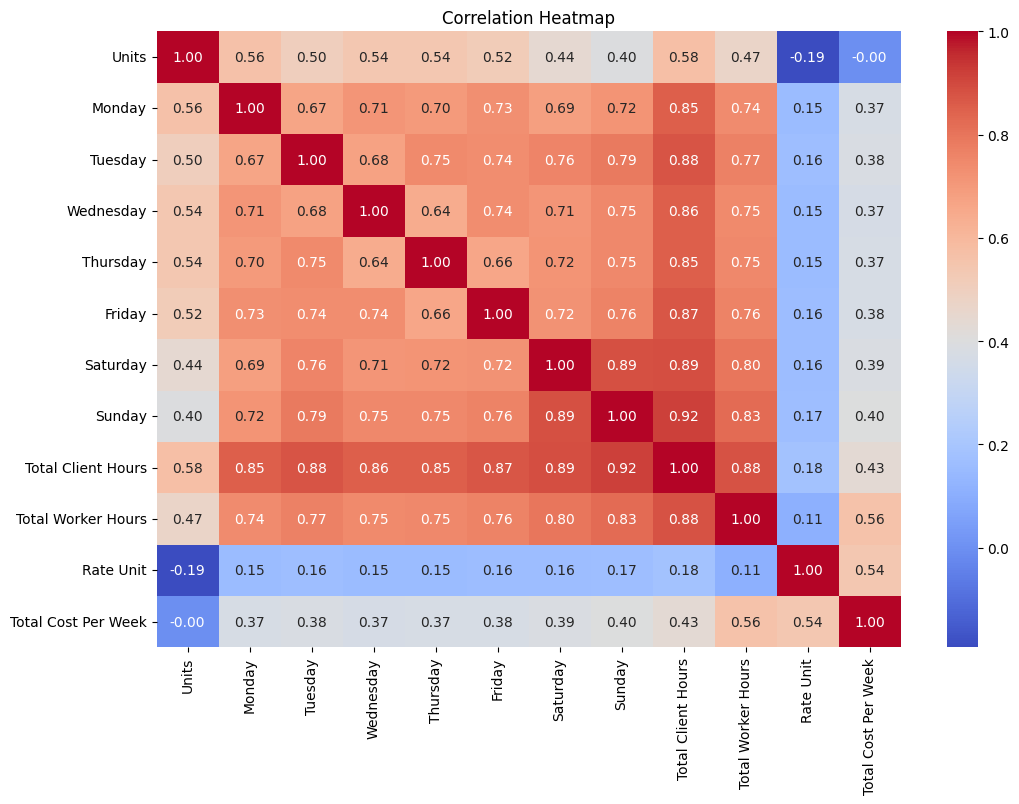

In [10]:
# Exploratory Data Analysis figures

# 1. Histogram and Box Plot for "Total Cost Per Week"
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Total Cost Per Week'], kde=True, color='blue')
plt.title('Distribution of Total Cost Per Week')
plt.xlabel('Total Cost Per Week')
plt.ylabel('Frequency')

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Total Cost Per Week'])
plt.title('Box Plot of Total Cost Per Week')
plt.ylabel('Total Cost Per Week')

plt.tight_layout()
plt.show()

# 3. Bar Chart for "Provider ID"
provider_counts = df['Provider ID'].value_counts()
plt.figure(figsize=(15, 6))
sns.barplot(x=provider_counts.index, y=provider_counts.values, palette='viridis')
plt.title('Number of Services Provided by each Provider')
plt.xlabel('Provider ID')
plt.ylabel('Number of Services')
plt.xticks(rotation=45)
plt.show()

# 4. Correlation Heatmap with specific variables of interest that may show a relationship between each other
numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()
selected_correlation_matrix = correlation_matrix.iloc[2:-7, 2:-7]
plt.figure(figsize=(12, 8))
sns.heatmap(selected_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
